Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


using device cpu
Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


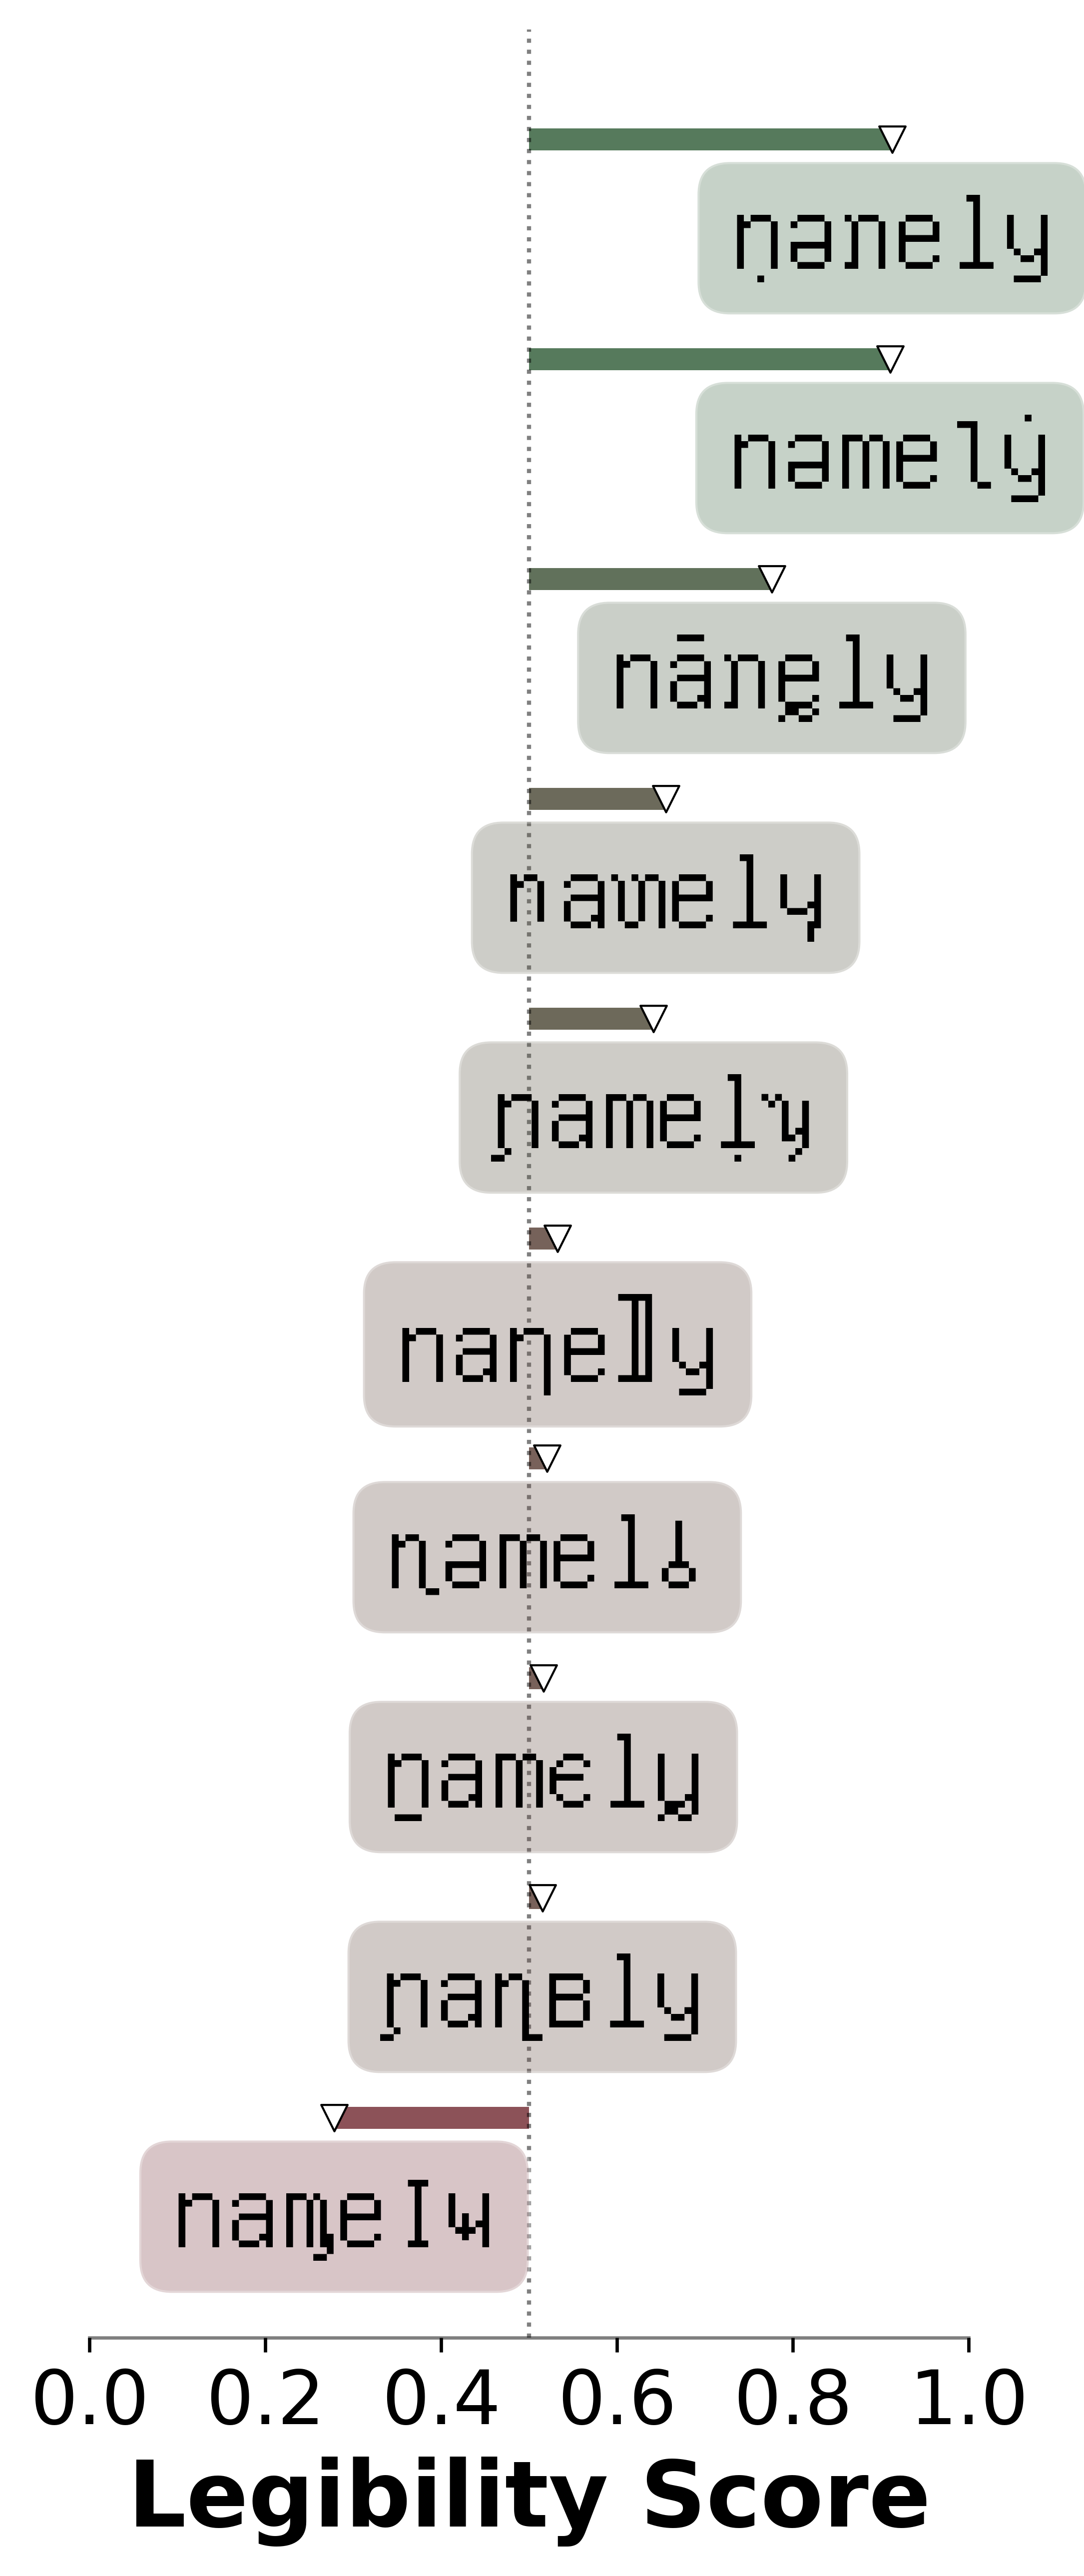

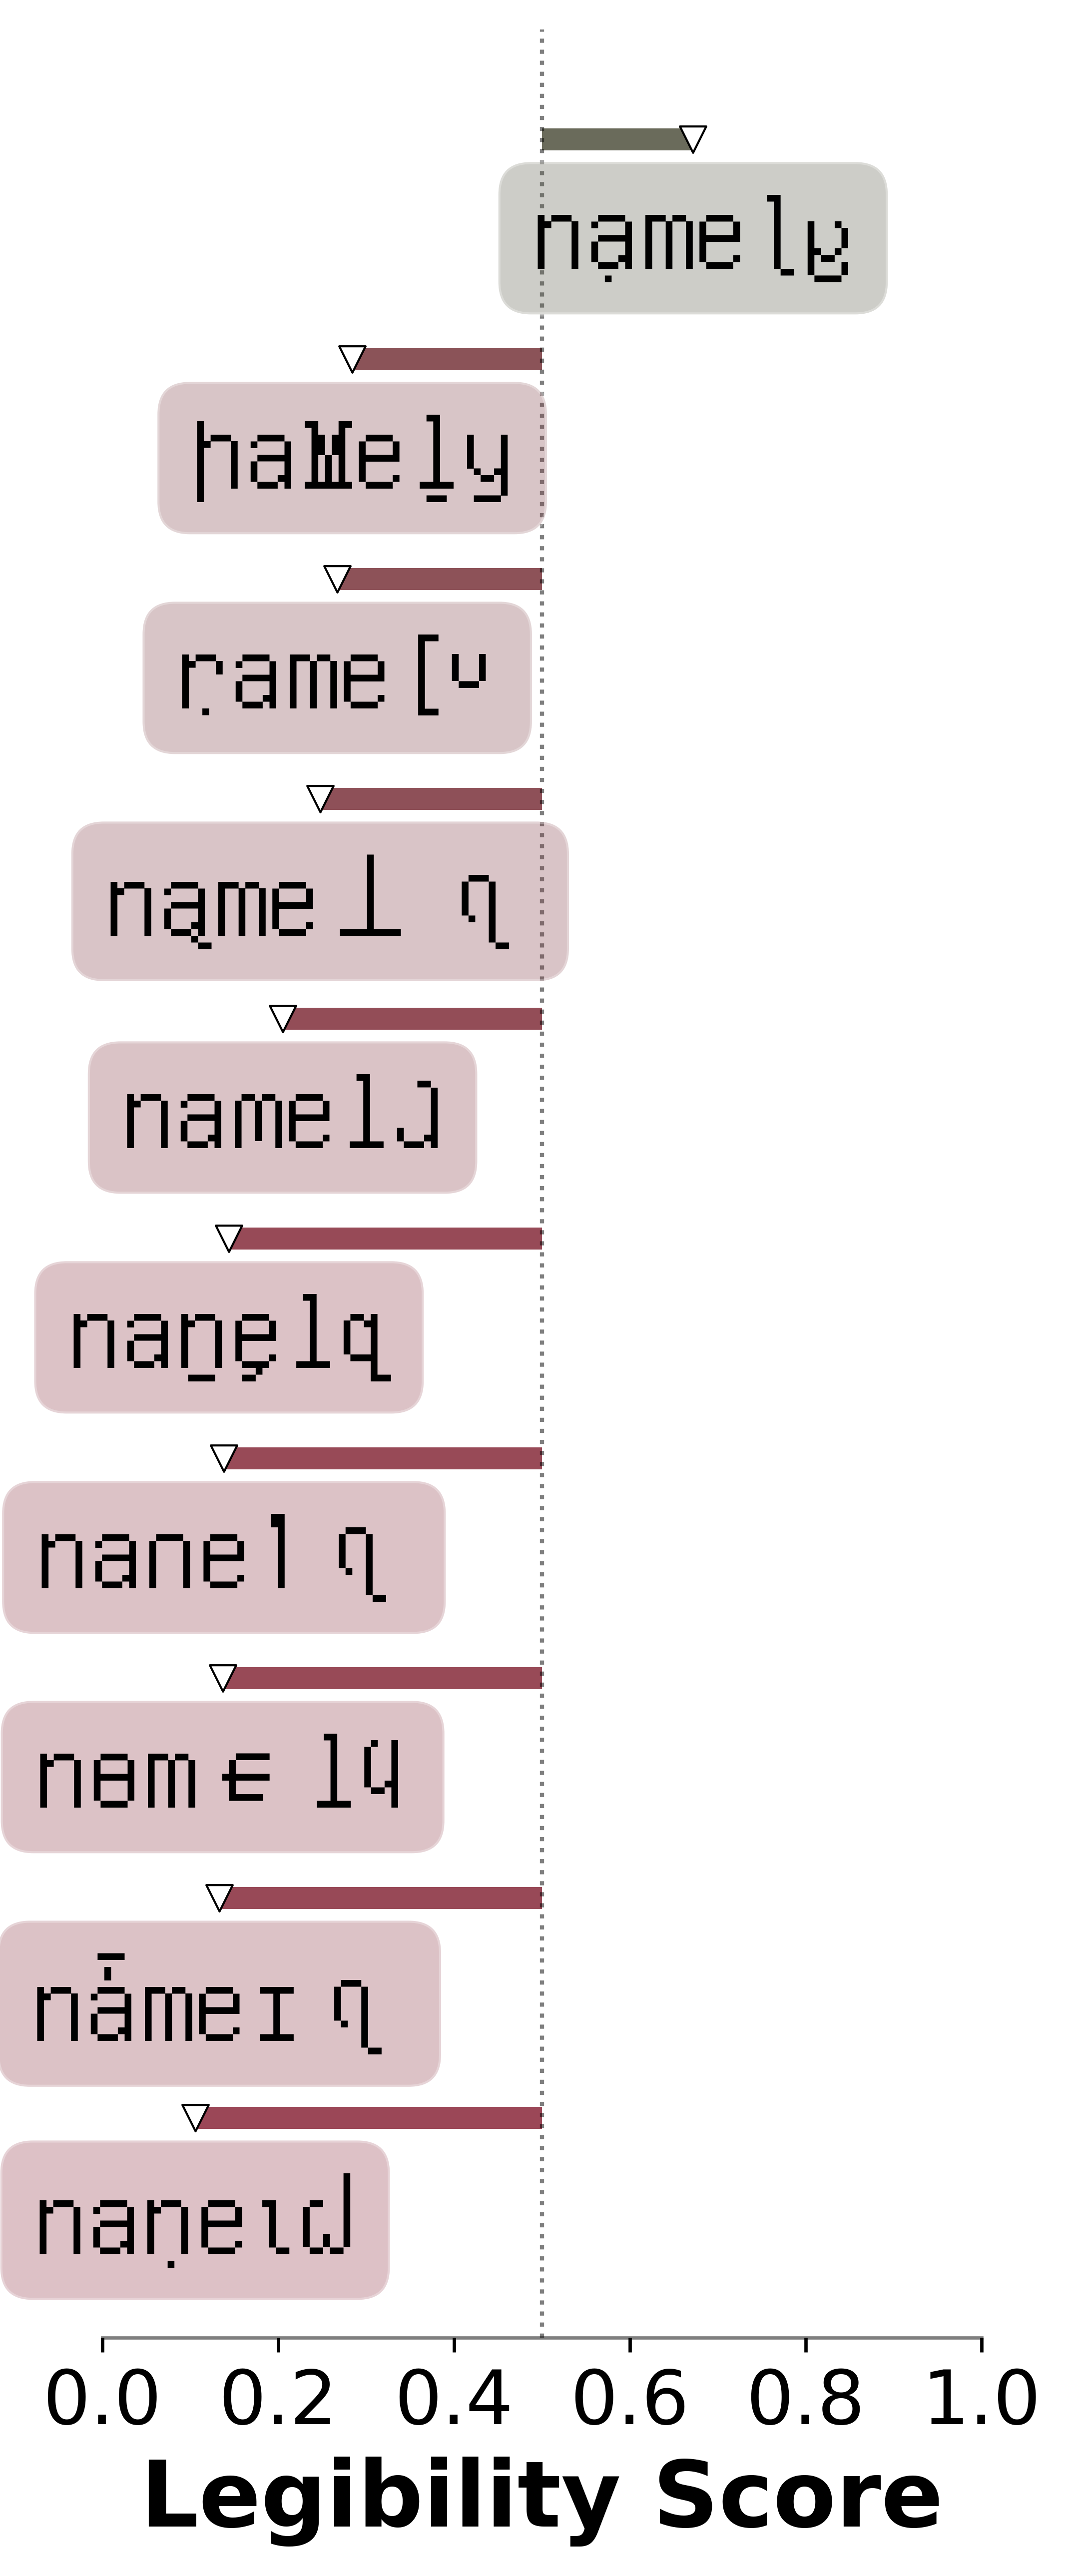

In [33]:
import gradio as gr
import numpy as np
from classes.Perturber import Perturber
from classes.Renderer import Renderer
from classes.LegibilityPlot import LegibilityPlot

import torch
from transformers import TrOCRProcessor, AutoModel, TrainingArguments

# preprocessor provides image normalization and resizing
preprocessor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-handwritten")

# load the model schema and pretrained weights
# (this may take some time to download)
model = AutoModel.from_pretrained("dvsth/LEGIT-TrOCR-MT", revision='main', trust_remote_code=True)

perturber = Perturber('trocr', 50)
renderer = Renderer('unifont.ttf')
plotter = LegibilityPlot()

def demo(word_to_perturb, k, n):
    if ' ' in word_to_perturb:
        return 'Please enter a single word.'

    perturbations, metadatas, images, scores = [], [], [], []
    for i in range(10):
        perturbation, metadata = perturber.perturb_word(word_to_perturb, k, n)
        inputimg = renderer.render_image(perturbation, word_to_perturb)
        score = model(preprocessor(inputimg, return_tensors='pt').pixel_values).item()
        
        metadata['score'] = score
        outputimg = renderer.render_image(perturbation, '')

        perturbations.append(perturbation)
        images.append(outputimg)
        metadatas.append(metadata)
        scores.append(score)

    # sort perturbations by score
    perturbations = [perturbation for perturbation, score in sorted(zip(perturbations, scores), key=lambda x: x[1])]
    scores = sorted(scores)
    images = [image for image, score in sorted(zip(images, scores), key=lambda x: x[1])]
    metadatas = [metadata for metadata, score in sorted(zip(metadatas, scores), key=lambda x: x[1])]

    # return as a single string in the format
    # perturbation1 (score1)
    # perturbation2 (score2)
    # ...
    # perturbationN (scoreN)
    # with all scores rounded to 2 decimal places
    ret_str = ''
    for i in range(len(perturbations)):
        ret_str += f'{perturbations[i]} ({round(scores[i], 2)}) -- ' + ("legible" if scores[i] > 0 else "not legible") + '\n'
        
    # plot the perturbations and scores
    fig = plotter.plot(scores, perturbations)
    return ret_str, fig

interface = gr.Interface(fn=demo, inputs=["text", gr.Slider(1, 50, 20, step=1), gr.Slider(0., 1., 0.5)], outputs=["text", "plot"], allow_flagging='never')

interface.launch()